<a href="https://colab.research.google.com/github/blaze010/CS6700-Reinforcement_Learning/blob/main/Assignment%201/Programming_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center >CS6700: Reinforcement Learning
## <center >Programming Assignment 1
## <center> TD Learning: SARSA and Q-Learning
###  Submitted by: 
### Gautham Govind A: EE19B022
### Vishnu Vinod: CS19B048 

## Importing necessary packages

In [1]:
from math import floor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Utility functions

We require functions capable of converting from row-column based indexing and sequential indexing of grid cells. These are defined below: 

In [2]:
# Converts row_column format to sequential (state number) format
# Input  - 2D array of grid cells in (row, col) format
# Output - 1D array of corresponding state numbers
def row_col_to_seq(row_col, num_cols): 
    return row_col[:,0] * num_cols + row_col[:,1]

# Converts sequential (state number) format to row_column format 
# Input  - 1D array of grid cells in state number format
# Output - 2D array of grid cells in corresponding (row, col) format 
def seq_to_col_row(seq, num_cols): 
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

In [3]:
row_col_to_seq(np.array([[1,0]]), 2)

array([2])

## Defining the environment

The environment class, the definition of which has already been provided as part of the problem statement, is defined here:

In [4]:
class GridWorld:

    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters:
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind
    
        # added to help naming conventions
        self.wind_mode = None
        self.start_mode = None
        self.stochasticity = None
        
        # 'windy' if wind=True | 'clear' if wind=False
        self.wind_mode = '_windy' if wind else '_clear'
        
        # 's1' if starting from [0,4] | 's2' if starting from [3,6] | None otherwise
        if (start_state == np.array([[0,4]])).all(): self.start_mode = '_s1'
        elif (start_state == np.array([[3,6]])).all(): self.start_mode = '_s2'
        

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias
        
        # 'detrm' if deterministic (p=1) | 'noisy' if stochastic (p!=1)
        self.stochasticity = '_detrm' if (p_good_transition == 1.) else '_noisy'

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal
        
        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):
                        
                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
        return int(self.start_state_seq)
      
    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            
            p += self.P[state, next_state, action]
            
            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):
            arr = self.P[next_state, :, 3]
            next_next = np.where(arr == np.amax(arr))
            next_next = next_next[0][0]
            return next_next, self.R[next_next]
        else:
            return next_state, self.R[next_state]

## Policy Definitions

First, we create an abstract BasePolicy() class:

In [5]:
class BasePolicy:
    @property
    def name(self):
        return 'base_policy'

    def select_action(self, state_id):
        raise NotImplemented

We first create an epsilon greedy policy which makes use of action value functions as the quantity based on which actions are chosen:

In [6]:
class EpsilonGreedy(BasePolicy):
    # epsilon      : epsilon value to be used by epsilon-greedy
    # actions      : Possible actions that can be taken up in each state
    #              : Default set for the current problem
    def __init__(self, epsilon, actions = np.array([0, 1, 2, 3])):
        self.eps = epsilon
        self.actions = actions
        
    # return name of policy
    @property
    def name(self):
        return '_eps'

    # action_values: 2D array containing predicted action values for each (state, action) pair
    #              : array size is |S|*4, i.e, total number of states x total number of actions
    # state_id     : state for which action is to be determined
    def select_action(self, state_id, action_values):
        # To explore or not to explore, that is the question
        explore_or_exploit = np.random.binomial(1, 1 - self.eps)

        # if exploit, select the arm with maximum value of action value function else choose random arm
        if explore_or_exploit == 1:
            return self.actions[np.argmax(action_values[state_id, :])]
        else:
            return np.random.choice(self.actions)

In [7]:
class SoftMax(BasePolicy):

    # beta      : temperature to be used by softmax function
    def __init__(self, beta, actions = np.array([0, 1, 2, 3])):
        self.beta = beta
        self.actions = actions
        
    # return name of policy
    @property
    def name(self):
        return '_smx'

    # action_values: 2D array containing predicted action values for each (state, action) pair
    #              : array size is |S|*4, i.e, total number of states x total number of actions
    # state_id     : state for which action is to be determined
    def select_action(self, state_id, action_values):

        # Finding the largest action value for this particular state
        max_action_val = max(action_values[state_id, :])

        # Computing the denominator of the softmax expression
        # Note that each term is divided by the largest exponential
        softmax_prob_denom = np.sum(np.exp((action_values[state_id, :] - max_action_val)/self.beta))

        # Computing the numerator term for each action
        # Again, terms are divided by the largest exponential to maintatin consistency with denominator
        softmax_prob = np.array([ np.exp((x - max_action_val) /self.beta)/softmax_prob_denom for x in list(action_values[state_id, :])])

        # sample according to the softmax distribution to get an arm
        return np.random.choice(self.actions, p = softmax_prob)

## SARSA

In [8]:
class BaseUpdate:
    @property
    def name(self):
        return 'base_policy'
    
    def update(self, state_id):
        raise NotImplemented

We first define the SARSA update rule:

In [9]:
class SARSA(BaseUpdate):
    # alpha - learning rate
    # gamma - discount factor
    def __init__(self, alpha, gamma):
        self.alpha = alpha
        self.gamma = gamma
        
    # return name of policy
    @property
    def name(self):
        return 'sarsa'
    
    # q_current - Current estimate for a particular (state,action) pair
    # q_future - Future estimates for all actions on a particular state
    # reward - reward
    # next_action - specifies next action
    def update(self, q_current, q_future, reward, next_action = None):
        return q_current + self.alpha*(reward + self.gamma*q_future[next_action] - q_current)

## Q-Learning 

We now define the Q-Learning update rule

In [10]:
class QLearning(BaseUpdate):
    # alpha - learning rate
    # gamma - discount factor
    def __init__(self, alpha, gamma):
        self.alpha = alpha
        self.gamma = gamma
        
    # return name of policy
    @property
    def name(self):
        return 'qlrng'
    
    # q_current - Current estimate for a particular (state,action) pair
    # q_future - Future estimates for all actions on a particular state
    # reward - reward
    # next_action - specifies next action (redundant here)
    def update(self, q_current, q_future, reward, next_action = None):
        q_future_max = max(q_future)
        return q_current + self.alpha*(reward + self.gamma * q_future_max - q_current)

## Iterator for Experiments

In [11]:
class TrainingIterator:
    def __init__(self, env, update_policy, exploration_policy, episodes):
        self.env = env                         # Grid World Env
        self.num_eps = episodes                # training episodes
        self.update_policy = update_policy     # SARSA vs Q-Learning
        self.explore = exploration_policy      # epsilon-greedy vs softmax
        
        self.steps = np.zeros(episodes)                                # total_steps for each episode
        self.rewards = np.zeros(episodes)                              # total_rewards for each episode
        self.q_vals = np.zeros((env.num_states, env.num_actions))      # Qvalues for each (state,action) pair
        self.hmap_visits = np.zeros(env.num_states)                    # heatmap of state visits (during training)
        self.hmap_qvals = np.zeros(env.num_states)                     # heatmap of Qvalues for optimal actions (after training)
        
    def train(self):
        
        # iterate over training episodes
        for episode in range(self.num_eps):
            
            current_state  = row_col_to_seq(self.env.start_state, self.env.num_cols)[0]
            current_action = self.explore.select_action(current_state, self.q_vals)

            self.steps[episode] = 0
            self.rewards[episode] = 0
            self.hmap_visits[current_state] += 1

            while((current_state not in list(row_col_to_seq(self.env.goal_states, self.env.num_cols))) and (self.steps[episode] <= 100)):

#                 if episode == (self.num_eps-1):
#                     print(seq_to_col_row(current_state, self.env.num_cols), end = '-->')

                next_state, reward = self.env.step(current_state, current_action)
                next_action = self.explore.select_action(next_state, self.q_vals)
                self.q_vals[current_state, current_action] = self.update_policy.update(self.q_vals[current_state, current_action], self.q_vals[next_state], reward, next_action)
                
                if current_state != next_state:
                    self.hmap_visits[next_state] += 1
                    
                current_state = next_state
                current_action = next_action
                
                self.rewards[episode] += reward
                self.steps[episode] += 1
                
            if current_state not in list(row_col_to_seq(self.env.goal_states, self.env.num_cols)):
                self.steps[episode] = np.inf

#             if episode == (self.num_eps-1):
#                 print(seq_to_col_row(current_state, self.env.num_cols))
                
        for state in range(self.env.num_states):
            self.hmap_qvals[state] = max(self.q_vals[state])
            
        return
    
    def plot_reward_curve(self):
        name = self.update_policy.name + self.env.start_mode + self.env.wind_mode + self.env.stochasticity + self.explore.name + '_plt_rewards.jpg'
        
        sns.set_style("darkgrid")
        
        plt.title("Reward Curve")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.plot(np.arange(self.num_eps), self.rewards, 'b')
        
        plt.savefig('./plots/' + name, pad_inches = 0)
        plt.show()
        return
        
    def plot_steps(self):
        name = self.update_policy.name + self.env.start_mode + self.env.wind_mode + self.env.stochasticity + self.explore.name + '_plt_steps.jpg'
        
        sns.set_style("darkgrid")
        
        plt.title("Steps till Goal State")
        plt.xlabel("Episodes")
        plt.ylabel("Steps")
        plt.plot(np.arange(self.num_eps), self.steps, 'g')
        
        plt.savefig('./plots/' + name, pad_inches = 0)
        plt.show()
        return
        
    def plot_hmap_visits(self):
        name = self.update_policy.name + self.env.start_mode + self.env.wind_mode + self.env.stochasticity + self.explore.name + '_hmp_visits.jpg'
        
        n_rows, n_cols = self.env.num_rows, self.env.num_cols
        data = np.zeros((n_rows, n_cols))
        for i in range(n_rows):
            for j in range(n_cols):
                data[i,j] = self.hmap_visits[row_col_to_seq(np.array([[i,j]]), n_cols)[0]]
            
        plt.title("Heatmap of State Visits")
        hmap = sns.heatmap(data, annot = False)
        plt.savefig('./plots/' + name, pad_inches = 0)
        plt.show()
        return
        
    def plot_hmap_qvals(self):
        name = self.update_policy.name + self.env.start_mode + self.env.wind_mode + self.env.stochasticity + self.explore.name + '_hmp_qvals.jpg'
        
        n_rows, n_cols = self.env.num_rows, self.env.num_cols
        data = np.zeros((n_rows, n_cols))
        for i in range(n_rows):
            for j in range(n_cols):
                data[i,j] = self.hmap_qvals[row_col_to_seq(np.array([[i,j]]), n_cols)[0]]
            
        plt.title("Heatmap of Q-Values")
        hmap = sns.heatmap(data, annot = False)
        plt.savefig('./plots/' + name, pad_inches = 0)
        plt.show()

## Experiment 1

In [12]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[0,4]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-20,
               restart_state_reward=-100)

gw.add_transition_probability(p_good_transition=1.0, bias=0.5)

env = gw.create_gridworld()

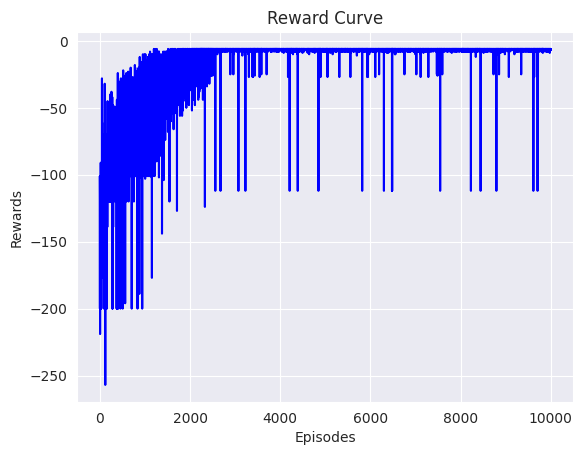

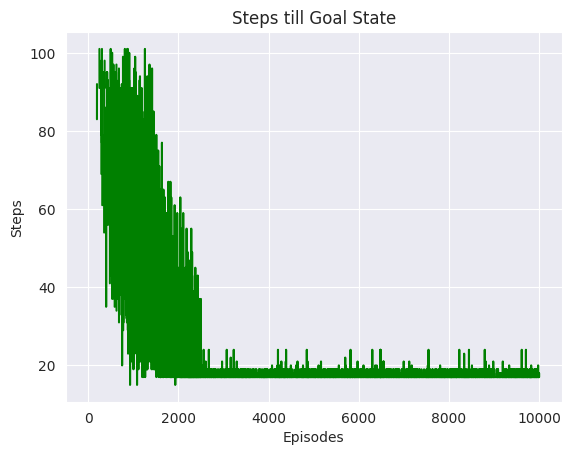

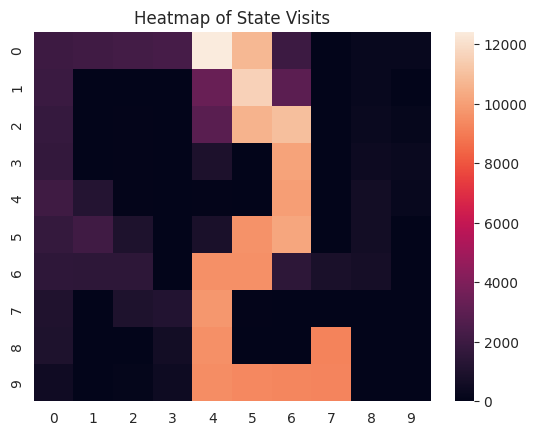

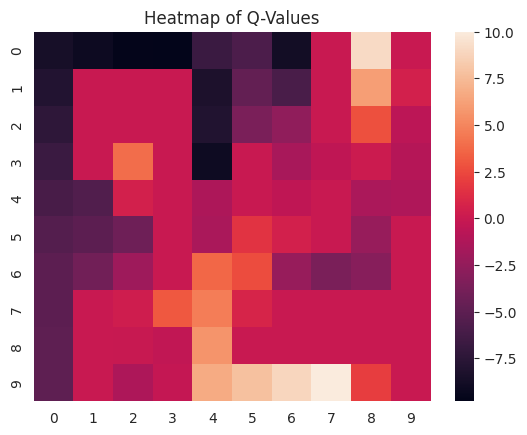

In [13]:
eps_greedy = EpsilonGreedy(epsilon = 0.01)
sarsa_update = SARSA(alpha = 0.01, gamma = 1)
trainer = TrainingIterator(env, sarsa_update, eps_greedy, 10000)
trainer.train()

trainer.plot_reward_curve()
trainer.plot_steps()
trainer.plot_hmap_visits()
trainer.plot_hmap_qvals()